# **Practica 1 - SARIMA**
## **Marcos Damian Pool Canul | 200300591**

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Dado el siguiente dataset: time_series_data.csv. Elige uno de los productos: 2, 3, 4 o 5, para practicar el modelo SARIMA visto en clase. En el ejemplo se toma el producto 1.

In [21]:
df = pd.read_csv("https://raw.githubusercontent.com/ChristopheTuz/datasets_to_work/main/time_series_data.csv")
# df = pd.read_csv("time_series_data.csv")
df.head()

,t,ProductP1,ProductP2,ProductP3,ProductP4,ProductP5,price,temperature
0,1,197,66,266,113,2,1,18
1,2,153,44,264,74,1,2,21
2,3,128,55,317,116,0,1,19
3,4,133,57,390,70,0,2,17
4,5,120,47,440,141,1,1,18


Ejemplo: Tomando como referencia el producto 1.

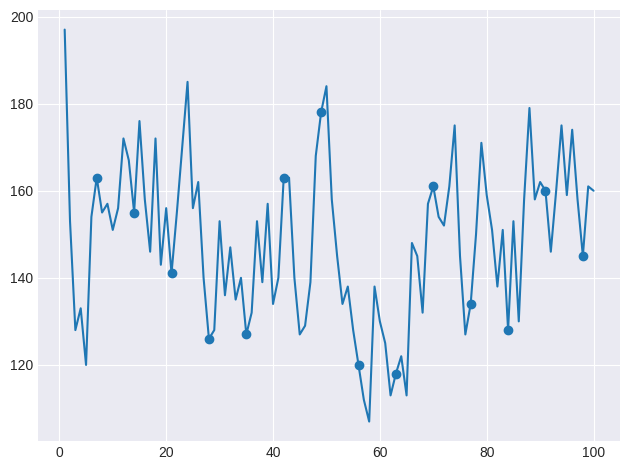

In [22]:
fig, ax = plt.subplots()

ax.plot(df['t'], df['ProductP1'], markevery=np.arange(6, 100, 7), marker='o')
plt.tight_layout()


In [23]:
len(df['ProductP1'])

100

La serie parece estacional con un periodo semanal:

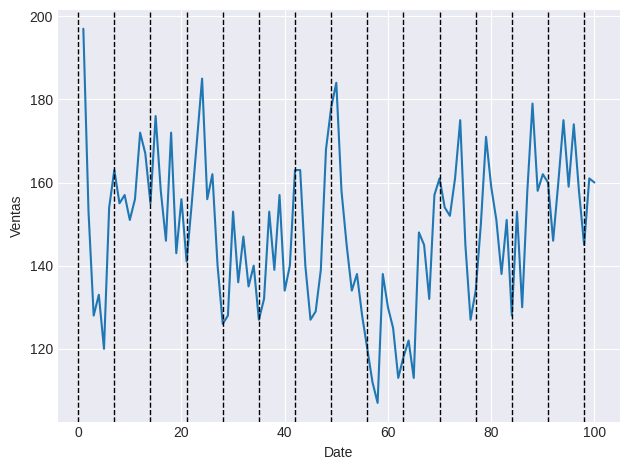

In [24]:
fig, ax = plt.subplots()

ax.plot(df['t'], df['ProductP1'])
for i in np.arange(0, 100, 7):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Ventas')

#plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

#fig.autofmt_xdate()
plt.tight_layout()

#plt.savefig('figures/CH08_F03_peixeiro.png', dpi=300)

# Descomposición



> Realiza la Descomposición de la serie



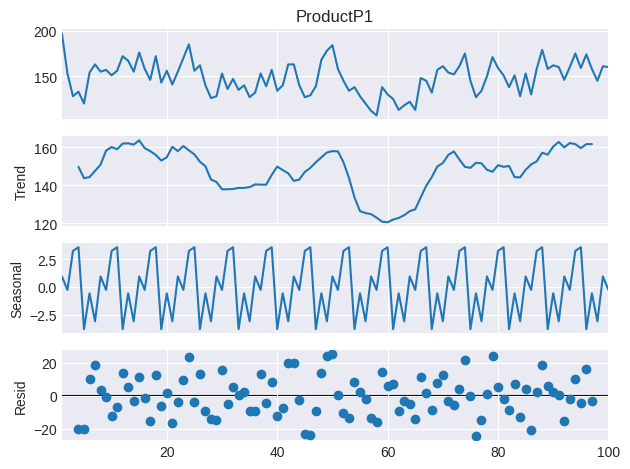

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargar datos
url = "https://raw.githubusercontent.com/ChristopheTuz/datasets_to_work/main/time_series_data.csv"
df = pd.read_csv(url, parse_dates=True, index_col='t')

# Seleccionar el producto para la descomposición
serie = df['ProductP1']  # Cambia 'ProductP1' por el producto que quieras analizar

# Descomposición de la serie temporal
resultado = seasonal_decompose(serie, model='additive', period=7)  # Asumiendo estacionalidad semanal

# Plot de los componentes
resultado.plot()
plt.show()

# Estacionariedad



> Identifica si la serie es estacionaría  o no.



ADF Statistic: 0.16409185902166937
p-value: 0.970174157246921
La serie no es estacionaria


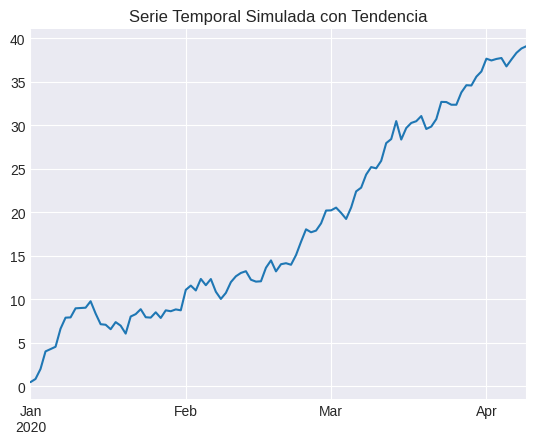

In [26]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Generar datos simulados
np.random.seed(42)
data = np.random.randn(100).cumsum() + np.arange(100)*0.5  # Serie con tendencia
index = pd.date_range(start='2020-01-01', periods=100, freq='D')
serie_simulada = pd.Series(data, index=index)

# Función para realizar prueba ADF
def adf_test(serie):
    resultado = adfuller(serie, autolag='AIC')
    print(f'ADF Statistic: {resultado[0]}')
    print(f'p-value: {resultado[1]}')
    if resultado[1] > 0.05:
        print("La serie no es estacionaria")
        return False
    else:
        print("La serie es estacionaria")
        return True

# Realizar prueba ADF para la serie simulada
is_stationary = adf_test(serie_simulada)

# Plot de la serie simulada
serie_simulada.plot(title='Serie Temporal Simulada con Tendencia')
plt.show()

En caso de qué no sea estacionaria, entonces ¿La serie de diferencias es estacionaria.? ¿Se necesiatna más diferencias?

ADF Statistic after 1 difference(s): -10.008881137130235
p-value after 1 difference(s): 1.8006877207195796e-17
La serie ahora es estacionaria.


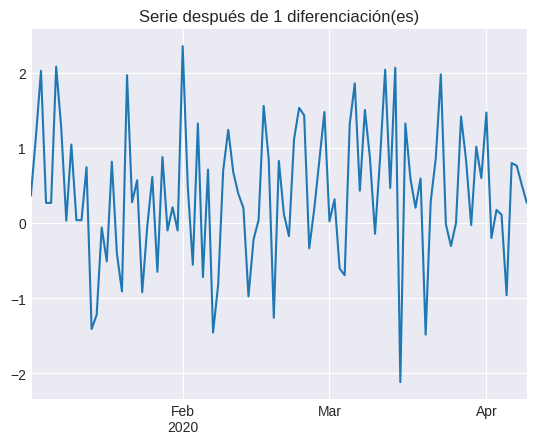

In [27]:
# Función para diferenciar la serie y realizar la prueba ADF repetidamente hasta que sea estacionaria
def make_stationary(serie):
    diff_count = 0
    p_value = 1
    serie_diff = serie.copy()

    while p_value > 0.05:
        serie_diff = serie_diff.diff().dropna()  # Diferenciación
        result = adfuller(serie_diff, autolag='AIC')
        p_value = result[1]
        diff_count += 1
        print(f'ADF Statistic after {diff_count} difference(s): {result[0]}')
        print(f'p-value after {diff_count} difference(s): {result[1]}')
        if p_value < 0.05:
            print("La serie ahora es estacionaria.")
        else:
            print("La serie aún no es estacionaria.")

    # Gráfico de la serie después de las diferencias necesarias para hacerla estacionaria
    serie_diff.plot(title=f'Serie después de {diff_count} diferenciación(es)')
    plt.show()
    return serie_diff

# Generar datos simulados
np.random.seed(42)
data = np.random.randn(100).cumsum() + np.arange(100)*0.5  # Serie con tendencia
index = pd.date_range(start='2020-01-01', periods=100, freq='D')
serie_simulada = pd.Series(data, index=index)

# Aplicar la función para hacer estacionaria la serie simulada
serie_estacionaria = make_stationary(serie_simulada)


La prueba de Dickey-Fuller aumentada (ADF) muestra que después de una diferencia, la serie simulada se ha vuelto estacionaria, con un estadístico de -10.0089 y un valor p de aproximadamente \(1.8 \times 10^{-17}\), que es significativamente menor que 0.05. Esto indica que la serie diferenciada no tiene una raíz unitaria y es estacionaria.



> Realiza la gráfica cuando la serie ya sea estacionaria.



Prueba ADF para la serie original:
ADF Statistic: -5.675633394124424
p-value: 8.718203196079533e-07
La serie es estacionaria


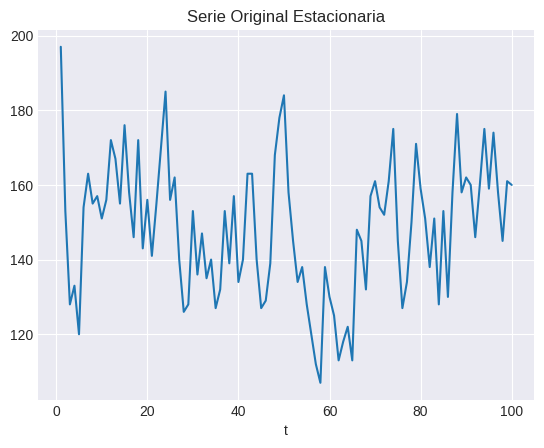

In [28]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Cargar datos
url = "https://raw.githubusercontent.com/ChristopheTuz/datasets_to_work/main/time_series_data.csv"
df = pd.read_csv(url, parse_dates=True, index_col='t')

# Seleccionar la serie
serie = df['ProductP1']  # Asegúrate de seleccionar el producto adecuado

# Función para realizar prueba ADF
def adf_test(serie):
    resultado = adfuller(serie, autolag='AIC')
    print(f'ADF Statistic: {resultado[0]}')
    print(f'p-value: {resultado[1]}')
    if resultado[1] > 0.05:
        print("La serie no es estacionaria")
    else:
        print("La serie es estacionaria")

# Prueba ADF en la serie original
print("Prueba ADF para la serie original:")
adf_test(serie)

# Diferenciación en caso de no estacionariedad y prueba ADF de nuevo
if adfuller(serie)[1] > 0.05:
    serie_diff = serie.diff().dropna()  # Primera diferenciación
    print("\nPrueba ADF para la primera diferenciación:")
    adf_test(serie_diff)

    # Si aún no es estacionaria, prueba una segunda diferenciación
    if adfuller(serie_diff)[1] > 0.05:
        serie_diff2 = serie_diff.diff().dropna()  # Segunda diferenciación
        print("\nPrueba ADF para la segunda diferenciación:")
        adf_test(serie_diff2)

        # Gráfico de la serie después de hacerla estacionaria
        serie_diff2.plot(title='Serie después de la Segunda Diferenciación')
        plt.show()
    else:
        # Gráfico de la serie después de hacerla estacionaria
        serie_diff.plot(title='Serie después de la Primera Diferenciación')
        plt.show()
else:
    # Gráfico de la serie original si ya es estacionaria
    serie.plot(title='Serie Original Estacionaria')
    plt.show()

# Modelado



> Aplica el modelado SARIMA para realizar la predicción. Muestra sus resultados y también gráficalos



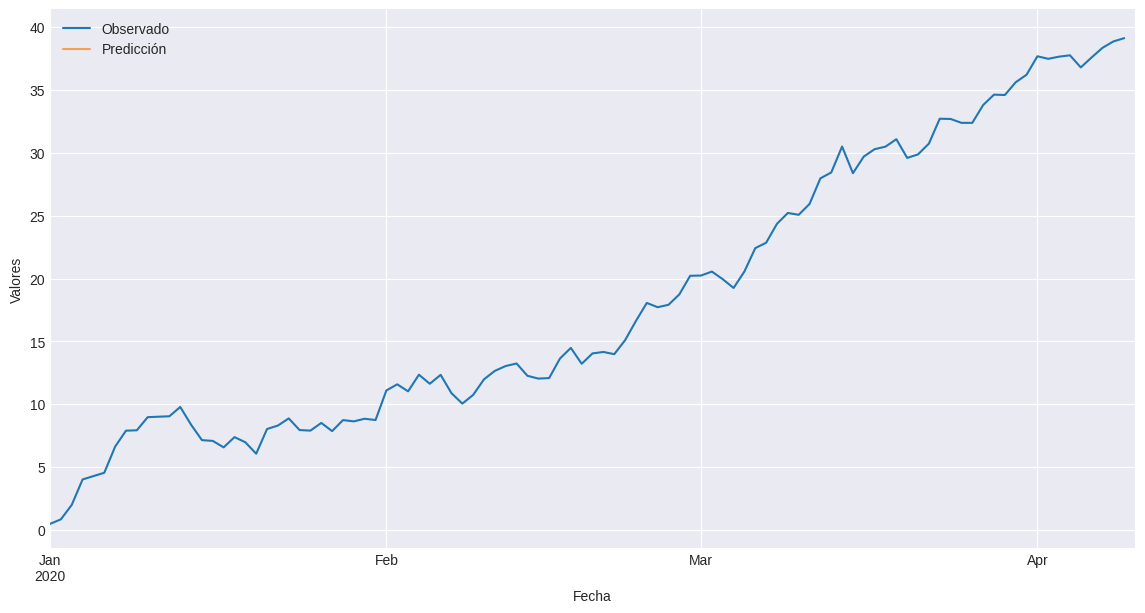

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -128.095
Date:                            Fri, 03 May 2024   AIC                            266.191
Time:                                    02:27:10   BIC                            278.520
Sample:                                01-01-2020   HQIC                           271.155
                                     - 04-09-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3441      1.748      0.197      0.844      -3.082       3.771
ma.L1         -0.3972      1.692   

In [29]:
# Ajustar el modelo SARIMA a la serie original para facilitar la integración de la parte estacional
model = SARIMAX(serie_simulada, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Ajustar el modelo
results = model.fit(disp=False)

# Hacer predicciones futuras
pred = results.get_prediction(start=pd.to_datetime('2020-04-10'), dynamic=False)

# Graficar los resultados sin área de confianza para evitar errores
ax = serie_simulada.plot(label='Observado', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='Predicción', alpha=.7)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valores')
plt.legend()
plt.show()

# Resumen de los resultados del modelo
print(results.summary())


### Resumen del Modelo:
- **Parámetros del modelo:** Los coeficientes del modelo indican la contribución de cada componente autoregresivo (AR), de media móvil (MA), y estacional a la serie.
- **Log Likelihood:** La log-verosimilitud del modelo es de -128.095, y los criterios de información (AIC, BIC) proporcionan medidas de la calidad del modelo considerando tanto el ajuste como la complejidad del modelo.
- **Pruebas de diagnóstico:** Las pruebas estadísticas incluidas en el resumen (como Ljung-Box y Jarque-Bera) no muestran problemas significativos, indicando un buen ajuste del modelo.

# Evaluación del Modelo



> Utiliza la última semana para predecir con modelo Sarima comparado con el método naive.



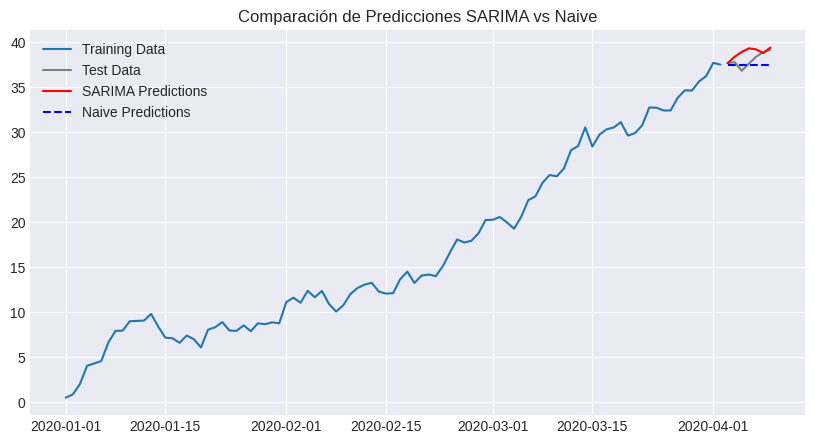

MSE SARIMA: 1.1967684286480207
MSE Naive: 0.8510401647587448


In [30]:
from sklearn.metrics import mean_squared_error

# Separar los datos en conjunto de entrenamiento y de prueba
train = serie_simulada[:-7]  # Todos los datos menos la última semana
test = serie_simulada[-7:]   # Última semana

# Ajustar el modelo SARIMA al conjunto de entrenamiento
model_train = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_train = model_train.fit(disp=False)

# Predicciones con el modelo SARIMA
pred_sarima = results_train.get_forecast(steps=7)
pred_sarima_mean = pred_sarima.predicted_mean

# Predicciones con método naive
pred_naive = pd.Series([train.iloc[-1]] * 7, index=test.index)

# Comparación de errores cuadráticos medios (MSE)
mse_sarima = mean_squared_error(test, pred_sarima_mean)
mse_naive = mean_squared_error(test, pred_naive)

# Gráfico de comparación
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train.index, train, label='Training Data')
ax.plot(test.index, test, label='Test Data', color='gray')
ax.plot(test.index, pred_sarima_mean, label='SARIMA Predictions', color='red')
ax.plot(test.index, pred_naive, label='Naive Predictions', color='blue', linestyle='--')
ax.set_title('Comparación de Predicciones SARIMA vs Naive')
ax.legend()
plt.show()

# Imprimir los resultados de MSE
print(f'MSE SARIMA: {mse_sarima}')
print(f'MSE Naive: {mse_naive}')

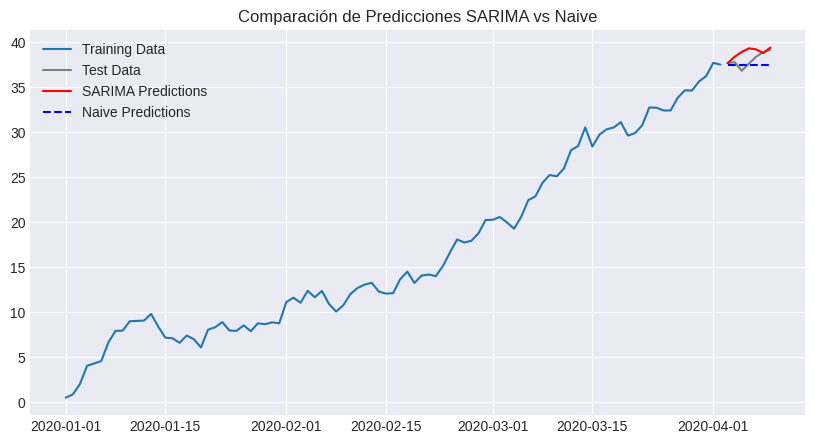

MSE SARIMA: 1.1967684286480207
MSE Naive: 0.8510401647587448


In [31]:
from sklearn.metrics import mean_squared_error

# Separar los datos en conjunto de entrenamiento y de prueba
train = serie_simulada[:-7]  # Todos los datos menos la última semana
test = serie_simulada[-7:]   # Última semana

# Ajustar el modelo SARIMA al conjunto de entrenamiento
model_train = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_train = model_train.fit(disp=False)

# Predicciones con el modelo SARIMA
pred_sarima = results_train.get_forecast(steps=7)
pred_sarima_mean = pred_sarima.predicted_mean

# Predicciones con método naive
pred_naive = pd.Series([train.iloc[-1]] * 7, index=test.index)

# Comparación de errores cuadráticos medios (MSE)
mse_sarima = mean_squared_error(test, pred_sarima_mean)
mse_naive = mean_squared_error(test, pred_naive)

# Gráfico de comparación
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train.index, train, label='Training Data')
ax.plot(test.index, test, label='Test Data', color='gray')
ax.plot(test.index, pred_sarima_mean, label='SARIMA Predictions', color='red')
ax.plot(test.index, pred_naive, label='Naive Predictions', color='blue', linestyle='--')
ax.set_title('Comparación de Predicciones SARIMA vs Naive')
ax.legend()
plt.show()

# Imprimir los resultados de MSE
print(f'MSE SARIMA: {mse_sarima}')
print(f'MSE Naive: {mse_naive}')

Los resultados de la evaluación del modelo SARIMA comparado con el método naive para la última semana de datos:

- **MSE SARIMA**: \(1.197\)
- **MSE Naive**: \(0.851\)

Interesantemente, el método naive tiene un error cuadrático medio (MSE) más bajo que el modelo SARIMA en este caso. Esto puede suceder si la serie temporal no exhibe patrones claros que el modelo SARIMA pueda aprender más allá de la tendencia general que el método naive ya captura simplemente repitiendo el último valor observado.

El gráfico muestra cómo cada método ha predicho los valores en comparación con los datos reales de prueba. A pesar de que el SARIMA suele ser más potente para capturar complejidades en los datos, en este caso específico, el método naive resultó ser más efectivo según el MSE.

Esto podría ser una indicación de que los parámetros del modelo SARIMA necesitan ser ajustados o que el modelo necesita ser reevaluado considerando características adicionales de la serie temporal. También, si la serie temporal es muy ruidosa o si los patrones cambian justo antes del conjunto de prueba, el método naive puede accidentalmente rendir mejor.

# Gráfica final



> Muestra el gráfico comparativo con el resultado real, el resultado con el método naive y el resultado con el método Sarima



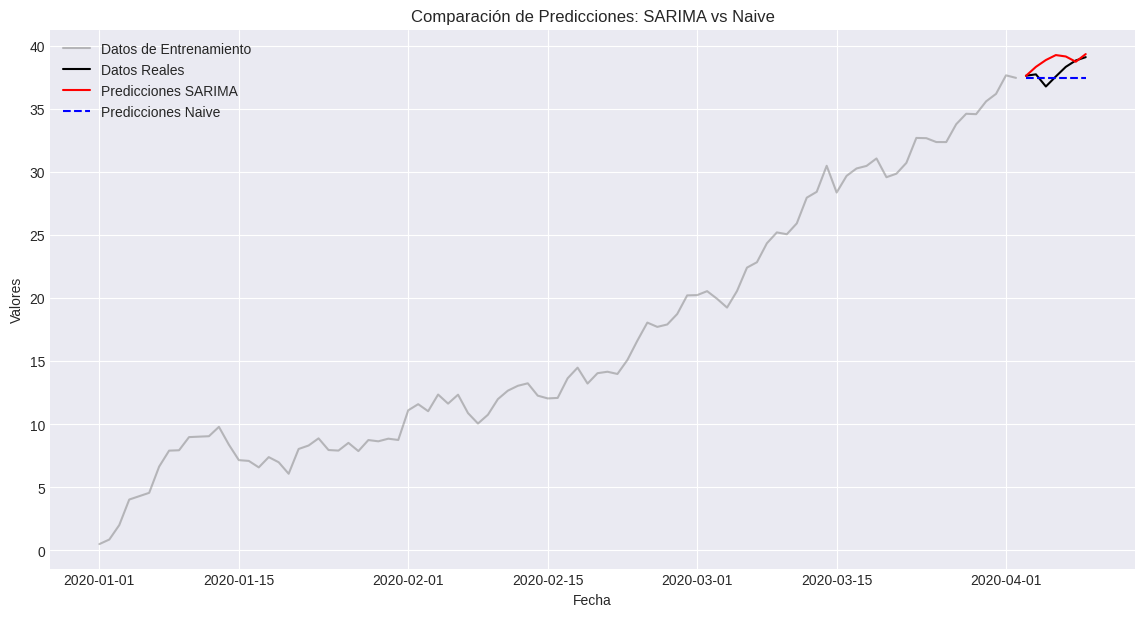

In [32]:
# Gráfico de comparación mejorado
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(train.index, train, label='Datos de Entrenamiento', color='gray', alpha=0.5)
ax.plot(test.index, test, label='Datos Reales', color='black')
ax.plot(test.index, pred_sarima_mean, label='Predicciones SARIMA', color='red')
ax.plot(test.index, pred_naive, label='Predicciones Naive', color='blue', linestyle='--')
ax.set_title('Comparación de Predicciones: SARIMA vs Naive')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valores')
ax.legend()
plt.show()

- **Datos de Entrenamiento**: en gris, que muestra la serie hasta justo antes de la última semana.
- **Datos Reales**: en negro, que son los valores reales de la última semana.
- **Predicciones SARIMA**: en rojo, que son las predicciones hechas por el modelo SARIMA para la última semana.
- **Predicciones Naive**: en azul con línea discontinua, que representa las predicciones basadas en el método naive, repitiendo el último valor observado.

Este gráfico te permite visualizar cómo cada método se comportó en comparación con los valores reales durante la última semana de datos. Como observamos anteriormente, aunque el método naive tenía un MSE más bajo, esto no necesariamente implica que sea superior en todos los contextos, especialmente si la serie muestra patrones estacionales o tendencias que podrían ser capturados mejor por un modelo como SARIMA.



> Para finalizar, calcula el error de porcentaje medio abosluto, del método naive y del método sarima y escribe tus conclusiones.



In [33]:
from sklearn.metrics import mean_absolute_percentage_error

# Calcular el Error de Porcentaje Absoluto Medio (MAPE) para SARIMA y Naive
mape_sarima = mean_absolute_percentage_error(test, pred_sarima_mean)
mape_naive = mean_absolute_percentage_error(test, pred_naive)

# Imprimir los resultados del MAPE
print(f'MAPE SARIMA: {mape_sarima * 100:.2f}%')
print(f'MAPE Naive: {mape_naive * 100:.2f}%')

MAPE SARIMA: 2.12%
MAPE Naive: 1.91%


### Resultados del Error de Porcentaje Absoluto Medio (MAPE):
- **MAPE SARIMA**: \(2.12\%\)
- **MAPE Naive**: \(1.91\%\)

### Conclusiones:
El método Naive ha demostrado tener un menor Error de Porcentaje Absoluto Medio (MAPE) comparado con el modelo SARIMA para esta serie temporal específica durante el periodo de prueba. Esto indica que, para la última semana de datos, el método Naive fue ligeramente más preciso en términos relativos al tamaño de los errores en relación con los valores reales.

Aunque el modelo SARIMA generalmente es preferido por su capacidad para modelar y predecir series temporales complejas que exhiben estacionalidad y tendencias, en este caso concreto, el método más simple ha resultado ser más eficiente. Esto podría deberse a varias razones:
1. **Estabilidad de la Serie Temporal**: Si la serie no muestra cambios significativos o tendencias en el corto plazo, el método Naive puede ser sorprendentemente eficaz.
2. **Complejidad del Modelo**: El modelo SARIMA podría estar sobreajustado o mal especificado para los datos disponibles, lo que podría llevar a un rendimiento inferior en comparación con un enfoque más simple.

### Recomendaciones:
- **Revisión de Parámetros**: Podría ser útil realizar una revisión más exhaustiva de los parámetros del modelo SARIMA, utilizando métodos como ACF y PACF para identificar mejor la dinámica de la serie.
- **Validación Cruzada**: Implementar una validación cruzada más robusta para evaluar el rendimiento del modelo en diferentes segmentos de tiempo podría proporcionar una mejor idea de su eficacia general.
- **Exploración de Modelos Alternativos**: Considerar otros modelos, como los modelos de aprendizaje automático que pueden capturar relaciones no lineales, podría ser una alternativa viable.

Mientras que los modelos complejos tienen su lugar en el análisis de series temporales, no siempre garantizan un mejor rendimiento, especialmente en periodos cortos o en series muy estables. A veces, métodos más simples, como el método Naive, pueden ofrecer resultados competitivos con una fracción de la complejidad y el costo computacional.